# Random Forest

In [1]:
# import all libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import time
import json

In [2]:
# Load the Training and Testing Data
x_train = pd.read_pickle('data/x_train.pkl')
y_train = pd.read_pickle('data/y_train.pkl')

x_test = pd.read_pickle('data/x_test.pkl')
y_test = pd.read_pickle('data/y_test.pkl')

## Implementing Basic Random Forest

In [3]:
# model
random_forest = RandomForestClassifier(random_state=1, 
                                       criterion='gini', 
                                       bootstrap=True, 
                                       max_features='auto',
                                       n_estimators=100, 
                                       max_depth=None, 
                                       min_samples_split=2)

# fit the model
random_forest.fit(x_train, y_train)

# prediction
predictions = random_forest.predict(x_test)

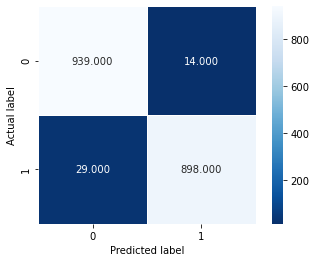

In [4]:
cm = confusion_matrix(y_test, predictions)
plt.figure()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

# plt.savefig('rf_cm_original.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Performance
f1_score_stroke_vanilla = f1_score(y_true=y_test, y_pred=predictions, pos_label=1)
f1_score_no_stroke_vanilla = f1_score(y_true=y_test, y_pred=predictions, pos_label=0)

f1_score_stroke_vanilla = round(f1_score_stroke_vanilla*100, 3)
f1_score_no_stroke_vanilla = round(f1_score_no_stroke_vanilla*100, 3)



print(f'F1 score for class Stroke = 1 --> {f1_score_stroke_vanilla}%')
print(f'F1 score for class Stroke = 0 --> {f1_score_no_stroke_vanilla}%')

F1 score for class Stroke = 1 --> 97.662%
F1 score for class Stroke = 0 --> 97.762%


In [6]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       953
           1       0.98      0.97      0.98       927

    accuracy                           0.98      1880
   macro avg       0.98      0.98      0.98      1880
weighted avg       0.98      0.98      0.98      1880



## Hyperparameter Tuning for Better Results

We will tune for:
- n_estimators - number of trees in a forest - 100 to 1000 with 100 increments
- max_depth - max depth till which a tree can grow to, None means there is no limit - 10 to 100 with 10 increments and None
- min_samples_split - minimum number of samples required to split an internal node - 2,3,4,5

In [7]:
# create a list of number of trees
n_estimators = list()
for i in range(100,1001,100):
    n_estimators.append(i)

# create a list of maximum depth till which a tree can grow
max_depth = list()
for i in range(10,101,10):
    max_depth.append(i)
max_depth.append(None)

# create a list of minimum samples required to split an internal node
min_samples_split = [2,3,4,5]

print(f'Number of values for n_estimators -> {len(n_estimators)}')
print(f'Number of values for max_depth -> {len(max_depth)}')
print(f'Number of values for min_samples_split -> {len(min_samples_split)}')

# Convert to dictionary
hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)

print(hyperparameters)

Number of values for n_estimators -> 10
Number of values for max_depth -> 11
Number of values for min_samples_split -> 4
{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 3, 4, 5]}


In [8]:
# Implement GridSearch to check and get the best hyperparameters

# estimator = ML model to be tested
# param_grid = dictionary of hyperparameters to be tested
# scoring = the scoring metric, for this imbalanced classification task, i chose f1
# n_jobs = number of cores to be used in parallel, -1 means use all
# cv = number of cross validation set elements

best_model = GridSearchCV(estimator=RandomForestClassifier(random_state=1, criterion='gini', bootstrap=True, max_features='auto'), 
                          param_grid=hyperparameters, 
                          scoring = 'f1',
                          n_jobs=-1,
                          cv=10)

# Fit the model
best_model = best_model.fit(x_train,y_train)

In [9]:
n_estimators = best_model.best_estimator_.get_params()['n_estimators']
max_depth = best_model.best_estimator_.get_params()['max_depth']
min_samples_split = best_model.best_estimator_.get_params()['min_samples_split']

print(f'Best n_estimators: {n_estimators}')
print(f'Best max_depth: {max_depth}')
print(f'Best min_samples_split: {min_samples_split}')

Best n_estimators: 300
Best max_depth: 30
Best min_samples_split: 2


## Use New Hyperparameters

In [10]:
# start timer
start_time = time.time()

# model
random_forest = RandomForestClassifier(random_state=1, 
                                       criterion='gini', 
                                       bootstrap=True, 
                                       max_features='auto',
                                       n_estimators=n_estimators, 
                                       max_depth=max_depth, 
                                       min_samples_split=min_samples_split)

# fit the model
random_forest.fit(x_train, y_train)

# Time to train
time_to_train = round(time.time() - start_time, 4)
print(f'Time to Train --> {time_to_train} seconds')

Time to Train --> 1.3958 seconds


In [11]:
# start timer
start_time = time.time()

# prediction
predictions = random_forest.predict(x_test)

# Inference time
inference_time = round(time.time() - start_time, 4)
print(f'Inference time --> {inference_time} seconds')

Inference time --> 0.0809 seconds


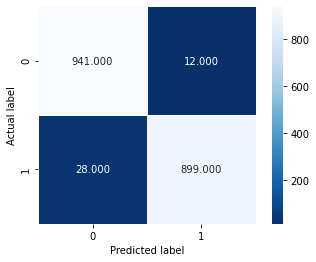

In [12]:
cm = confusion_matrix(y_test, predictions)
plt.figure()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

plt.savefig('rf_cm_hp_tune.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Performance after hyperparameter tuning
f1_score_stroke_hp_tuning = f1_score(y_true=y_test, y_pred=predictions, pos_label=1)
f1_score_no_stroke_hp_tuning = f1_score(y_true=y_test, y_pred=predictions, pos_label=0)

f1_score_stroke_hp_tuning = round(f1_score_stroke_hp_tuning*100, 3)
f1_score_no_stroke_hp_tuning = round(f1_score_no_stroke_hp_tuning*100, 3)

print(f'F1 score for class Stroke = 1 --> {f1_score_stroke_hp_tuning}%')
print(f'F1 score for class Stroke = 0 --> {f1_score_no_stroke_hp_tuning}%')

F1 score for class Stroke = 1 --> 97.824%
F1 score for class Stroke = 0 --> 97.919%


In [14]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       953
           1       0.99      0.97      0.98       927

    accuracy                           0.98      1880
   macro avg       0.98      0.98      0.98      1880
weighted avg       0.98      0.98      0.98      1880



In [15]:
# percentage improvement due to hyperparameter tuning
score_increase_stroke = round(((f1_score_stroke_hp_tuning - f1_score_stroke_vanilla)/f1_score_stroke_vanilla)*100, 3)
score_increase_no_stroke = round(((f1_score_no_stroke_hp_tuning - f1_score_no_stroke_vanilla)/f1_score_no_stroke_vanilla)*100, 3)

print(f'Percentage increase for F1 score with stroke --> {score_increase_stroke}%')
print(f'Percentage increase for F1 score without stroke --> {score_increase_no_stroke}%')

Percentage increase for F1 score with stroke --> 0.166%
Percentage increase for F1 score without stroke --> 0.161%


In [16]:
print(f1_score_stroke_vanilla)
print(f1_score_no_stroke_vanilla)
print('---------------------------------')
print(f1_score_stroke_hp_tuning)
print(f1_score_no_stroke_hp_tuning)
print('---------------------------------')
print(score_increase_stroke)
print(score_increase_no_stroke)
print('---------------------------------')
print(time_to_train)
print(inference_time)

97.662
97.762
---------------------------------
97.824
97.919
---------------------------------
0.166
0.161
---------------------------------
1.3958
0.0809


## Saving numbers to JSON

Since this isnt the first model, read the previously made JSON file and then add to it

In [18]:
# read previously created JSON
with open('results.json') as json_file:
    json_dict = json.load(json_file)

# add to it
json_dict['rf'] = {
    "scores_vanilla":{"with_stroke":f1_score_stroke_vanilla, "without_stroke":f1_score_no_stroke_vanilla},
    "scores_after_hp_tuning":{"with_stroke":f1_score_stroke_hp_tuning, "without_stroke":f1_score_no_stroke_hp_tuning},
    "percentage_increase":{"with_stroke":score_increase_stroke, "without_stroke":score_increase_no_stroke},
    "time":{"time_to_train_final_model":time_to_train, "inference_time_on_final_model":inference_time}}

In [19]:
with open('results.json', 'w') as fp:
    json.dump(json_dict, fp,  indent=4)